In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import NERCOME, shrinkage

In [3]:
# Parameters
p = 18
n = 4000
mean = 0
sigmaA = 1.1
sigmaB = 1.1

# Target matrix
T = np.identity(p)

# Build true covariance matrix
C_true_A = np.full(p//2, sigmaA**2)
C_true_B = np.full(p-p//2, sigmaB**2)
C_true = np.diag(np.concatenate((C_true_A, C_true_B)))

evals_MC_sum = np.zeros(p)
evals_MCS_sum = np.zeros(p)
evals_NERCOME_sum = np.zeros(p)
lmbda_est_all = []
s_min_all = []

# Number of simulations
m = 100
for _ in range(m):
    # Build random matrix
    A = np.random.normal(mean, sigmaA, size=(p//2, n))
    B = np.random.normal(mean, sigmaB, size=(p-p//2, n))
    X = np.vstack((A, B))
    
    # Perform imported algorithms
    C_shrinkage, S1, lmbda_est = shrinkage.shrinkage_cov_matrix(X, T)
    C_nercome, S2, s_min = NERCOME.NERCOME(X)
    
    # We require the empirically estimated covariance matrices to be (almost) identical
    assert np.allclose(S1, S2, 0, 1e-10)
    
    evals_MC = np.linalg.eigvalsh(S1)
    evals_MCS = np.linalg.eigvalsh(C_shrinkage)
    evals_NERCOME = np.linalg.eigvalsh(C_nercome)
    
    evals_MC_sum += evals_MC
    evals_MCS_sum += evals_MCS
    evals_NERCOME_sum += evals_NERCOME
    lmbda_est_all.append(lmbda_est)
    s_min_all.append(s_min)

evals_MC = evals_MC_sum / m
evals_MCS = evals_MCS_sum / m
evals_NERCOME_sum = evals_NERCOME / m

lmbda_est = np.average(lmbda_est_all)
lmbda_est_std = np.std(lmbda_est_all)

s_min = np.average(s_min_all)
s_min_std = np.std(s_min_all)

print(f"Lambda: {lmbda_est} ± {lmbda_est_std}")
print(f"s which minimizes Q: {s_min} ± {s_min_std}")

Lambda: 0.1375246725152492 ± 0.00666127575042239
s which minimizes Q: 1449.0 ± 1393.964490222043


In [4]:
print(s_min_all)

[3200, 3200, 1000, 126, 126, 2600, 2200, 126, 3200, 126, 600, 2800, 126, 2600, 126, 3000, 126, 2800, 1800, 3400, 126, 126, 2400, 126, 3400, 126, 3200, 126, 126, 126, 3400, 126, 126, 2200, 126, 126, 126, 3200, 126, 126, 2400, 2800, 126, 126, 3200, 3200, 3600, 126, 2600, 126, 126, 2200, 126, 3400, 126, 3200, 126, 3200, 126, 3200, 126, 126, 126, 3000, 126, 3000, 126, 2600, 3000, 1000, 2400, 2200, 2400, 3000, 126, 126, 3200, 3000, 126, 126, 3200, 126, 3400, 126, 2600, 3000, 2800, 126, 126, 126, 3000, 126, 126, 126, 126, 2800, 2800, 3000, 126, 126]


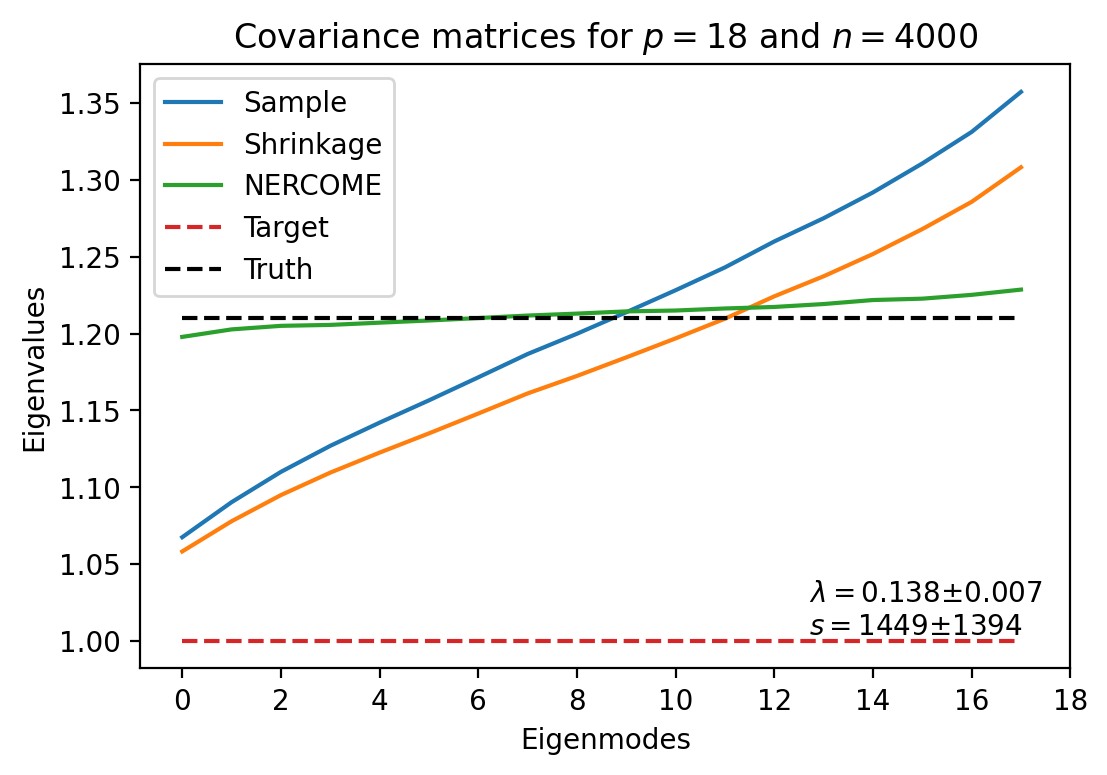

In [8]:
evals_T = np.linalg.eigvalsh(T)
evals_true = np.linalg.eigvalsh(C_true)

plt.figure(dpi=200)
plt.plot(evals_MC, label="Sample")
plt.plot(evals_MCS, label="Shrinkage")
plt.plot(evals_NERCOME, label="NERCOME")
plt.plot(evals_T, "--", label="Target")
plt.plot(evals_true, "k--", label="Truth")
plt.legend()
plt.title(fr"Covariance matrices for $p={p}$ and $n={n}$")
plt.xlabel("Eigenmodes")
plt.xticks(np.arange(0, 19, 2))
plt.ylabel("Eigenvalues")

text_box = AnchoredText(
    fr"$\lambda = {np.round(lmbda_est, 3)} ± {np.round(lmbda_est_std, 3)}$" "\n" fr"$s = {int(np.rint(s_min))} ± {int(np.rint(s_min_std))}$",
    frameon=False, loc=4, pad=0.5
)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)